In [1]:
import numpy as np
from matplotlib import pyplot as plt
import jax.numpy as jnp
from jax import jit, grad, jacfwd, jacrev

In [2]:
Q = np.diag([0.5, 1.0])

# Only for contour plot
def plot_f(X, Y):
    # equivalent to 0.5 * ([X,Y] - [1,0]).T @ Q @ ([X,Y] - [1,0])
    return 0.5*(0.5*(X-1)**2 + Y**2)

def f(x):
    B = np.array([1, 0])
    return 0.5 * (x - B).T @ Q @ (x - B)

def grad_f(x):
    B = np.array([1, 0])
    return Q @ (x - B)

def hess_f(x):
    return Q

In [3]:
A = np.array([ [1.0], [-1.0] ])
b = -1.0

# Inequality Constraint
# x₁ - x₂ ≤ -1
def c(x):
    return x@A - b

# Caution, output of ∂c should be a vector for gradient calculation 
def partial_c(x):
    return A

def partial_c_jnp(x):
    return jnp.array(A)

## Visualization

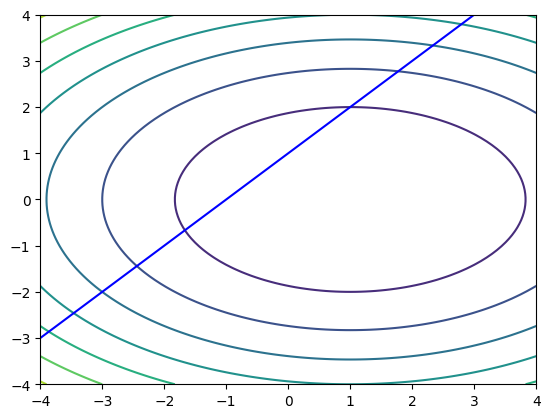

In [4]:
def plot_landscape():

    x = np.linspace(-4, 4, 100)
    y = np.linspace(-4, 4, 100)
    X, Y = np.meshgrid(x, y)
    Z = plot_f(X, Y)
    contour = plt.contour(X, Y, Z)
    
    xc = np.linspace(-4.0, 3.0, 100)
    plt.plot(xc, xc+1, color='blue')
    
plot_landscape()
plt.show()

## Define new cost function 

$min [ f(x) + \tilde{\lambda} c(x) + \frac{\rho}{2} {max(0, c(x))}^2 ]$

In [5]:
def L(x, λ, ρ):
    p = max(0, c(x))
    return f(x) + λ * c(x) + 0.5 * ρ * (p*p)

In [6]:
def newton_solve(x0, λ, ρ, verbose=False):

    x = x0
    print(f"c(x): {c(x)}")
    p = max(0, c(x)[0])
    
    C = np.zeros((2, 1))
    # filter active constraints
    if (c(x) >= 0).all():
        C = partial_c(x)

    # Calculate Gradient and Hessian only about the "x"
    grad_L = grad_f(x).reshape(2, 1) + C * λ + ρ * C * p 
    hess_L = hess_f(x) + ρ * C * C.T

    print(f"grad_L: {grad_L}")
    print(f"hess_L: {hess_L}")

    while np.linalg.norm(grad_L) > 1e-8:
        # update x, newton method
        dx = -np.linalg.inv(hess_L).dot(grad_L)
        dx = dx.flatten()
        x = x + dx

        # Calculate new Gradient and Hessian
        p = max(0, c(x)[0])
        
        C = np.zeros((2, 1))
        if (c(x) >= 0).all():
            C = partial_c(x)
            
        grad_L = grad_f(x).reshape(2, 1) + C * λ + ρ * C * p 
        hess_L = hess_f(x) + ρ * C * C.T

        if verbose:
            print(f"grad_L: {grad_L}")
            print(f"hess_L: {hess_L}")
            print(f"dx: {dx}")
            print(f"norm: {np.linalg.norm(grad_L)}")
        
    return x

## Case1. Pure Penalty Method

- no λ update
- no ρ update

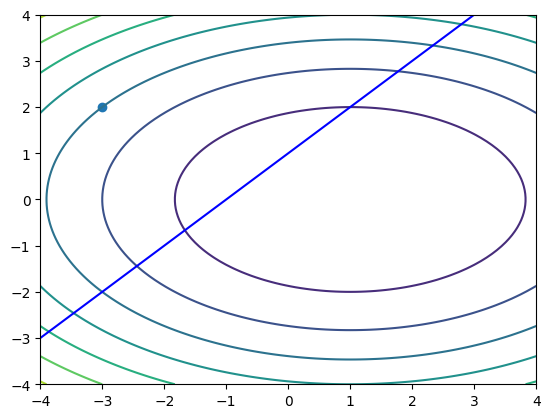

In [7]:
x_guess = np.array([[-3.0, 2.0]])
λ_guess = np.array([[0.0]])
ρ = 1.0
plot_landscape()
plt.scatter(x_guess[0][0], x_guess[0][1])
plt.show()

c(x): [0.5]
grad_L: [[ 1.11022302e-16]
 [-2.22044605e-16]]
hess_L: [[ 1.5 -1. ]
 [-1.   2. ]]


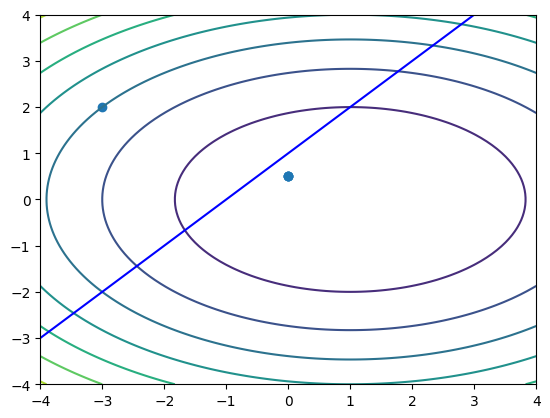

In [11]:
newx = newton_solve(x_guess[-1], λ_guess[-1], ρ)
x_guess = np.append(x_guess, [newx], axis=0)

plot_landscape()
plt.scatter(x_guess[:,0], x_guess[:,1])
plt.show()

In [12]:
x_guess

array([[-3. ,  2. ],
       [ 0. ,  0.5],
       [ 0. ,  0.5],
       [ 0. ,  0.5],
       [ 0. ,  0.5]])

## Case2. Penalty Method

- no λ update
- yes ρ update

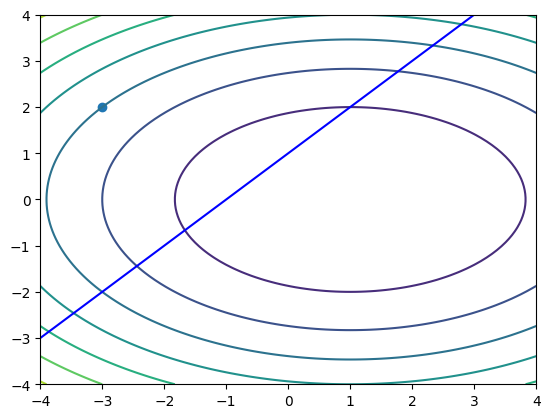

In [13]:
x_guess = np.array([[-3.0, 2.0]])
λ_guess = np.array([[0.0]])
ρ = 1.0
plot_landscape()
plt.scatter(x_guess[0][0], x_guess[0][1])
plt.show()

c(x): [0.00066644]
grad_L: [[ 5.99800067]
 [-5.99800067]]
hess_L: [[ 10000.5 -10000. ]
 [-10000.   10001. ]]


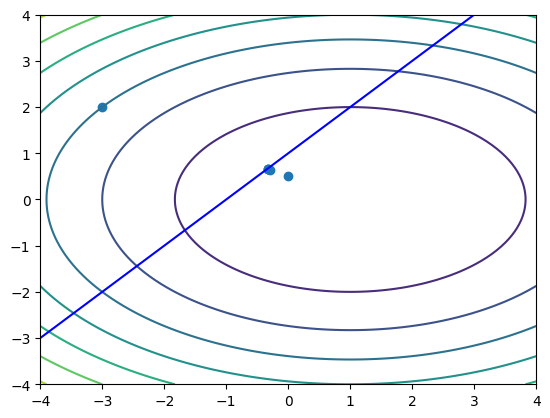

In [18]:
newx = newton_solve(x_guess[-1], λ_guess[-1], ρ)
x_guess = np.append(x_guess, [newx], axis=0)

ρ = 10 * ρ

plot_landscape()
plt.scatter(x_guess[:,0], x_guess[:,1])
plt.show()

### Getting Closer but doesn't converge


In [19]:
x_guess

array([[-3.        ,  2.        ],
       [ 0.        ,  0.5       ],
       [-0.29032258,  0.64516129],
       [-0.32890365,  0.66445183],
       [-0.33288904,  0.66644452],
       [-0.33328889,  0.66664445]])

## Case3. Only Lagrangian Update

- yes λ update
- no ρ update

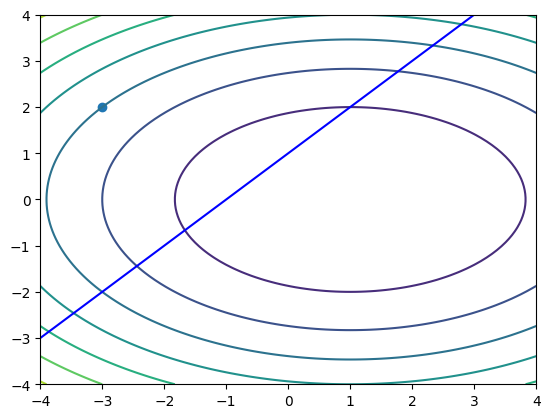

In [20]:
x_guess = np.array([[-3.0, 2.0]])
λ_guess = np.array([[0.0]])
ρ = 1.0
plot_landscape()
plt.scatter(x_guess[0][0], x_guess[0][1])
plt.show()

c(x): [0.00195312]
grad_L: [[ 0.00195312]
 [-0.00195312]]
hess_L: [[ 1.5 -1. ]
 [-1.   2. ]]


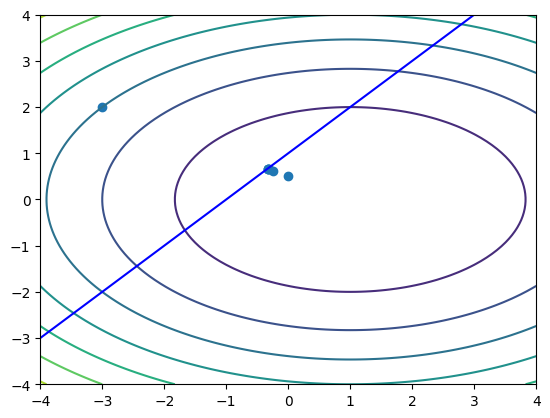

In [27]:
newx = newton_solve(x_guess[-1], λ_guess[-1], ρ)
x_guess = np.append(x_guess, [newx], axis=0)

newλ = λ_guess[-1] + ρ * max(0, c(newx)[0])
λ_guess = np.append(λ_guess, [newλ], axis=0)
# ρ = 10 * ρ

plot_landscape()
plt.scatter(x_guess[:,0], x_guess[:,1])
plt.show()

### Slowly converge

In [28]:
x_guess, λ_guess

(array([[-3.        ,  2.        ],
        [ 0.        ,  0.5       ],
        [-0.25      ,  0.625     ],
        [-0.3125    ,  0.65625   ],
        [-0.328125  ,  0.6640625 ],
        [-0.33203125,  0.66601562],
        [-0.33300781,  0.66650391]]),
 array([[0.        ],
        [0.5       ],
        [0.625     ],
        [0.65625   ],
        [0.6640625 ],
        [0.66601562],
        [0.66650391]]))

## [Best Case] Case4. Everything switched on

- yes λ update
- yes ρ update

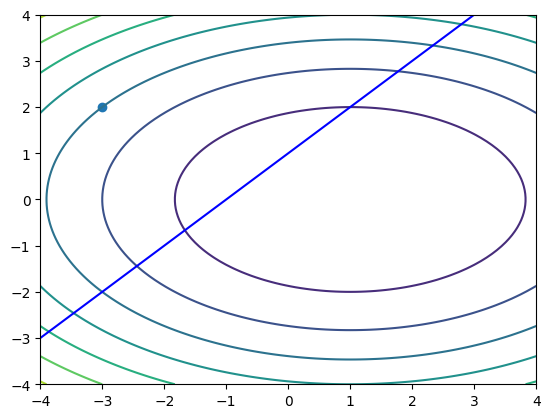

In [29]:
x_guess = np.array([[-3.0, 2.0]])
λ_guess = np.array([[0.0]])
ρ = 1.0
plot_landscape()
plt.scatter(x_guess[0][0], x_guess[0][1])
plt.show()

c(x): [5.35848248e-05]
grad_L: [[ 0.05358482]
 [-0.05358482]]
hess_L: [[ 1000.5 -1000. ]
 [-1000.   1001. ]]
grad_L: [[ 3.15303339e-14]
 [-3.15303339e-14]]
hess_L: [[ 1000.5 -1000. ]
 [-1000.   1001. ]]
dx: [-3.57113127e-05  1.78556564e-05]
norm: 4.459062582661921e-14


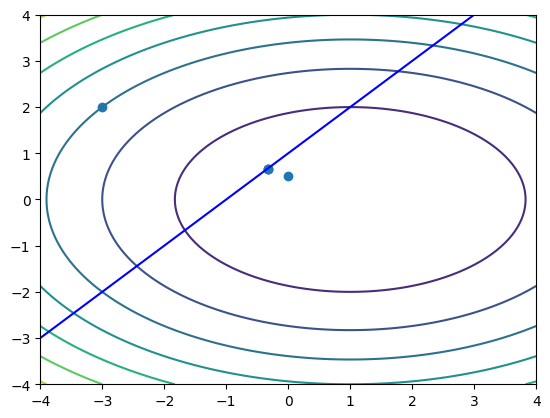

In [33]:
newx = newton_solve(x_guess[-1], λ_guess[-1], ρ, True)
x_guess = np.append(x_guess, [newx], axis=0)

newλ = λ_guess[-1] + ρ * max(0, c(newx)[0])
λ_guess = np.append(λ_guess, [newλ], axis=0)
ρ = 10 * ρ

plot_landscape()
plt.scatter(x_guess[:,0], x_guess[:,1])
plt.show()

In [34]:
x_guess, λ_guess

(array([[-3.        ,  2.        ],
        [ 0.        ,  0.5       ],
        [-0.32258065,  0.66129032],
        [-0.33329761,  0.66664881],
        [-0.33333332,  0.66666666]]),
 array([[0.        ],
        [0.5       ],
        [0.66129032],
        [0.66664881],
        [0.66666666]]))